# **Step 1 : Importing Necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from geopy.distance import geodesic


# **Step 2 : Loading the Dataset**

In [ ]:
file_path = "/content/train.csv"
df = pd.read_csv(file_path, low_memory= False)


In [ ]:
# Display the first few rows of the dataset
print(df.head(20))

                              key  fare_amount          pickup_datetime  \
0     2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1     2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2    2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3     2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4   2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   
5     2011-01-06 09:50:45.0000002         12.1  2011-01-06 09:50:45 UTC   
6     2012-11-20 20:35:00.0000001          7.5  2012-11-20 20:35:00 UTC   
7    2012-01-04 17:22:00.00000081         16.5  2012-01-04 17:22:00 UTC   
8   2012-12-03 13:10:00.000000125          9.0  2012-12-03 13:10:00 UTC   
9    2009-09-02 01:11:00.00000083          8.9  2009-09-02 01:11:00 UTC   
10    2012-04-08 07:30:50.0000002          5.3  2012-04-08 07:30:50 UTC   
11   2012-12-24 11:24:00.00000098          5.5  2012-12-24 11:24:00 UTC   
12    2009-11-06 01:04:03

In [ ]:
# Check the column names and the data types of the dataset
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                50000 non-null  object 
 1   fare_amount        50000 non-null  float64
 2   pickup_datetime    50000 non-null  object 
 3   pickup_longitude   50000 non-null  float64
 4   pickup_latitude    50000 non-null  float64
 5   dropoff_longitude  50000 non-null  float64
 6   dropoff_latitude   50000 non-null  float64
 7   passenger_count    50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB
None


# **Step 3: Data Preprocessing**

In [ ]:
# Convert 'pickup_datetime' to datetime type
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])


In [ ]:
# Feature extraction from 'pickup_datetime'
df['pickup_year'] = df['pickup_datetime'].dt.year
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday


In [ ]:
# Remove rows with missing or zero values for longitude/latitude
df = df[(df['pickup_longitude'] != 0) & (df['pickup_latitude'] != 0) &
        (df['dropoff_longitude'] != 0) & (df['dropoff_latitude'] != 0)]


# **Step 4: Feature Engineering**

In [ ]:
# Define a function to check if latitudes and longitudes are valid
def is_valid_location(lat, lon):
    return -90 <= lat <= 90 and -180 <= lon <= 180


In [ ]:
# Calculate the distance between pickup and dropoff using geodesic distance
df['pickup_coords'] = list(zip(df['pickup_latitude'], df['pickup_longitude']))
df['dropoff_coords'] = list(zip(df['dropoff_latitude'], df['dropoff_longitude']))


In [ ]:
# Only calculate distance if the coordinates are valid
df['distance'] = df.apply(
    lambda row: geodesic(row['pickup_coords'], row['dropoff_coords']).km
    if is_valid_location(row['pickup_latitude'], row['pickup_longitude']) and
       is_valid_location(row['dropoff_latitude'], row['dropoff_longitude'])
    else np.nan, axis=1
)

In [ ]:
# Drop rows with invalid distances (NaN values)
df = df.dropna(subset=['distance'])


# **Step 4: Data Visualization**

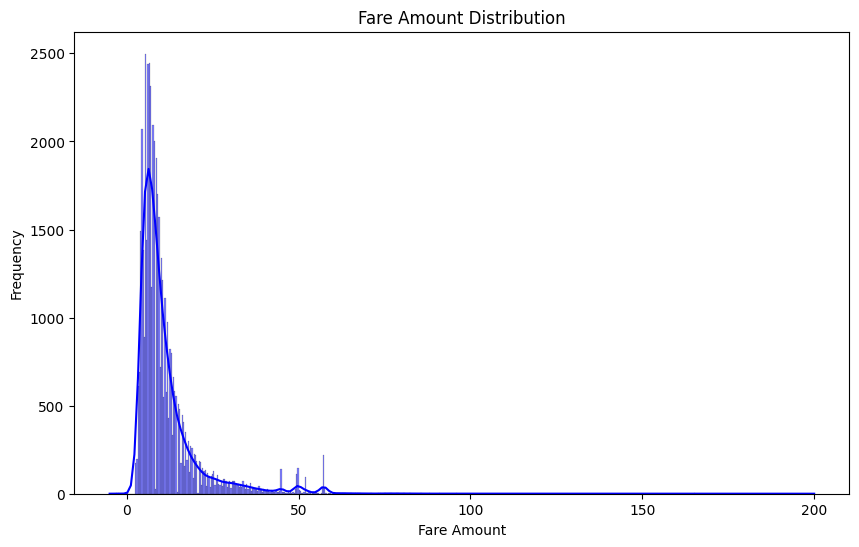

In [ ]:
# Visualize the fare distribution
plt.figure(figsize=(10,6))
sns.histplot(df['fare_amount'], kde=True, color='blue')
plt.title('Fare Amount Distribution')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.show()

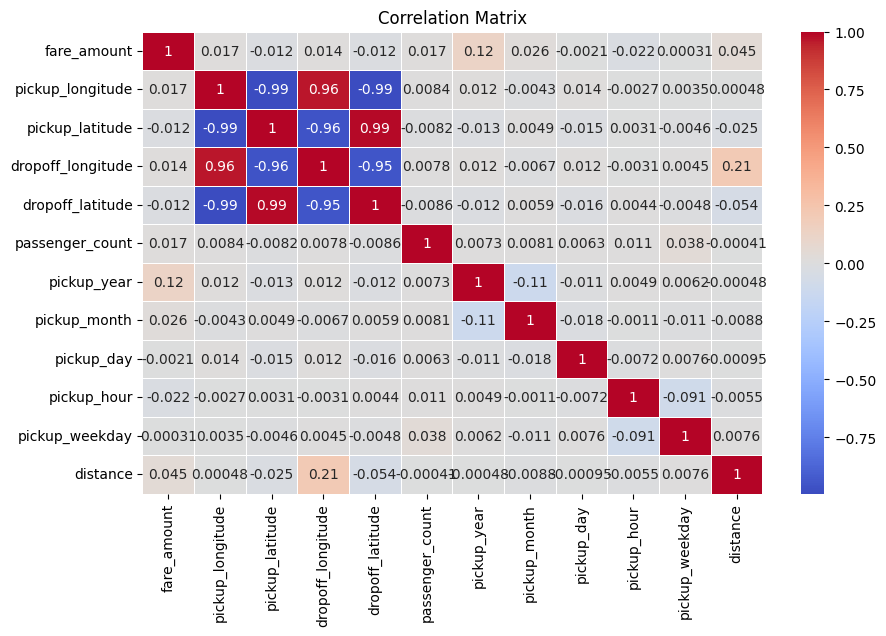

In [ ]:
# Visualize correlation matrix (only numerical columns)
numeric_df = df.select_dtypes(include=[np.number])  # Select only numerical columns
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# Step 5 : Data Cleaning before we build a Random Forest Model

In [ ]:
# Ensure that we only drop the columns that exist

# Drop 'fare_amount' (target variable) and 'pickup_datetime' (non-numeric)
X = df.drop(columns=[col for col in ['fare_amount', 'pickup_datetime'] if col in df.columns])

In [ ]:
# Ensure all columns in X are numeric
X = X.select_dtypes(include=[np.number])

## **Step 6 : Now Training and Deploying Random Forest Model**

In [ ]:
y = df['fare_amount']  # Target variable

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Building the Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

# **Step 8: Making Predictions**

In [ ]:

y_pred = rf_model.predict(X_test)


# **Step 9: Evaluation Metrics**

In [ ]:

def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)


    # Return metrics for further use if needed
    return r2, mae, mse, rmse


In [ ]:
# Use the evaluate_model function to get the metrics
rf_r2, rf_mae, rf_mse, rf_rmse = evaluate_model(y_test, y_pred)

# Print metrics for Random Forest

print(f"Random Forest - MAE: {rf_mae}")
print(f"Random Forest - RMSE: {rf_rmse}")
print(f"Random Forest - MSE: {rf_mse}")
print(f"Random Forest - R2 Score: {rf_r2}")


Random Forest - MAE: 1.9715556020408165
Random Forest - RMSE: 4.358366917343805
Random Forest - MSE: 18.995362186196942
Random Forest - R2 Score: 0.8017429789489484


# **Step 9 : Now Training a Regression Model on the same data**

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize and train the Multilinear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
lr_y_pred = lr_model.predict(X_test)

# Evaluate model using the evaluate function
lr_r2, lr_mae, lr_mse, lr_rmse = evaluate_model(y_test, lr_y_pred)

# Print metrics
print(f"Multilinear Regression - R2 Score: {lr_r2}")
print(f"Multilinear Regression - MAE: {lr_mae}")
print(f"Multilinear Regression - MSE: {lr_mse}")
print(f"Multilinear Regression - RMSE: {lr_rmse}")


Multilinear Regression - R2 Score: 0.01668208619790268
Multilinear Regression - MAE: 5.8602080889798875
Multilinear Regression - MSE: 94.21345997142102
Multilinear Regression - RMSE: 9.70636182982177


# **Step 10 : Now Training a Decisiom Tree Model**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Initialize and train the Decision Tree Regressor model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Predictions
dt_y_pred = dt_model.predict(X_test)

# Evaluate model using the evaluate function
dt_r2, dt_mae, dt_mse, dt_rmse = evaluate_model(y_test, dt_y_pred)

# Print metrics
print(f"Decision Tree Regressor - R2 Score: {dt_r2}")
print(f"Decision Tree Regressor - MAE: {dt_mae}")
print(f"Decision Tree Regressor - MSE: {dt_mse}")
print(f"Decision Tree Regressor - RMSE: {dt_rmse}")


Decision Tree Regressor - R2 Score: 0.6438615742334233
Decision Tree Regressor - MAE: 2.711215306122449
Decision Tree Regressor - MSE: 34.12226386734694
Decision Tree Regressor - RMSE: 5.841426526743868


# **Step 11 : Comparing the performances of these 3 models**

In [ ]:
import pandas as pd

# Storing results in a DataFrame for easy comparison
results = {
    "Model": ["Random Forest", "Multilinear Regression", "Decision Tree Regressor"],
    "R2 Score": [rf_r2, lr_r2, dt_r2],
    "MAE": [rf_mae, lr_mae, dt_mae],
    "MSE": [rf_mse, lr_mse, dt_mse],
    "RMSE": [rf_rmse, lr_rmse, dt_rmse]
}

results_df = pd.DataFrame(results)
print(results_df)


                     Model  R2 Score       MAE        MSE      RMSE
0            Random Forest  0.801743  1.971556  18.995362  4.358367
1   Multilinear Regression  0.016682  5.860208  94.213460  9.706362
2  Decision Tree Regressor  0.643862  2.711215  34.122264  5.841427


# **Step 12 : Random Forest seems to be clear winner, with max R2 score and minimum error**

In [ ]:
# Feature Importances
feature_importances = rf_model.feature_importances_
features = X.columns


# **Step 13 : We can also visualize feature importance**

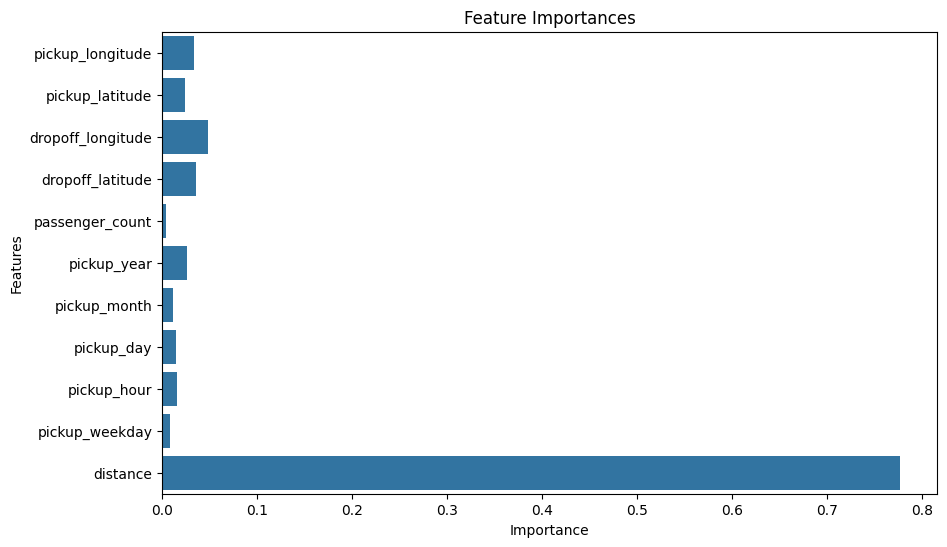

In [ ]:
# Plot feature importances
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# **Step 14 : Lastly, defining a user defined function, to take inputs from user and predict taxi fares**

In [ ]:
# Function to predict fare
def predict_fare(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon, passenger_count, pickup_hour, pickup_day, pickup_month, pickup_weekday, pickup_year, model=rf_model):
    # Create input DataFrame with the same structure as training data
    input_data = pd.DataFrame({
        'pickup_latitude': [pickup_lat],
        'pickup_longitude': [pickup_lon],
        'dropoff_latitude': [dropoff_lat],
        'dropoff_longitude': [dropoff_lon],
        'passenger_count': [passenger_count],
        'pickup_hour': [pickup_hour],
        'pickup_day': [pickup_day],
        'pickup_month': [pickup_month],
        'pickup_weekday': [pickup_weekday],
        'pickup_year': [pickup_year],  # Added pickup_year
        'distance': [geodesic((pickup_lat, pickup_lon), (dropoff_lat, dropoff_lon)).km]
    })

    # Ensure input data has the same feature order as the model
    input_data = input_data[X.columns]

    # Predicting the fare
    fare_prediction = model.predict(input_data)
    return fare_prediction[0]

# Get user input for prediction
pickup_lat = float(input("Enter pickup latitude: "))
pickup_lon = float(input("Enter pickup longitude: "))
dropoff_lat = float(input("Enter dropoff latitude: "))
dropoff_lon = float(input("Enter dropoff longitude: "))
passenger_count = int(input("Enter passenger count: "))
pickup_hour = int(input("Enter pickup hour (0-23): "))
pickup_day = int(input("Enter pickup day (1-31): "))
pickup_month = int(input("Enter pickup month (1-12): "))
pickup_weekday = int(input("Enter pickup weekday (0 for Monday, 6 for Sunday): "))
pickup_year = int(input("Enter pickup year: "))  # Added year input

# Calling the function to predict fare based on user input
predicted_fare = predict_fare(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon, passenger_count, pickup_hour, pickup_day, pickup_month, pickup_weekday, pickup_year)
print(f'Predicted Fare: ${predicted_fare:.2f}')


Enter pickup latitude: 40.71
Enter pickup longitude: -73.84
Enter dropoff latitude: 40.72
Enter dropoff longitude: -73.84
Enter passenger count: 1
Enter pickup hour (0-23): 17
Enter pickup day (1-31): 15
Enter pickup month (1-12): 6
Enter pickup weekday (0 for Monday, 6 for Sunday): 2009
Enter pickup year: 2009
Predicted Fare: $6.59
